# Gold Price Prediction

Bu notebook, negatif R² problemini çözmek için geliştirilmiş feature engineering içerir.

## İyileştirmeler:
- **Tarih Özellikleri**: Year, Month, Day, DayOfWeek, Quarter
- **Teknik İndikatörler**: MA, RSI, MACD, Bollinger Bands
- **algo_test** fonksiyonu ile çoklu model karşılaştırması

## 1. Kütüphanelerin Yüklenmesi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",100)

from sklearn.linear_model import LinearRegression,SGDRegressor,Ridge,Lasso,ElasticNet
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree, ExtraTreeRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline

## 2. algo_test Fonksiyonu Tanımı

In [2]:
def algo_test(x,y):
    # Bütün modelleri tanımlıyorum
    L=LinearRegression()
    R=Ridge()
    Lass=Lasso()
    E=ElasticNet()
    sgd=SGDRegressor()
    ETR=ExtraTreeRegressor()
    GBR=GradientBoostingRegressor()
    kn=KNeighborsRegressor()
    ada=AdaBoostRegressor()
    dt=DecisionTreeRegressor()
    xgb=XGBRegressor()
    svr=SVR()
    mlp_regressor = MLPRegressor()

    algos=[L,R,Lass,E,sgd,ETR,GBR,ada,kn,dt,xgb,svr,mlp_regressor]
    algo_names=['Linear','Ridge','Lasso','ElasticNet','SGD','Extra Tree','Gradient Boosting',
                'AdaBoost','KNeighborsRegressor','Decision Tree','XGBRegressor','SVR','mlp_regressor']
    
    x=MinMaxScaler().fit_transform(x)
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=.20,random_state=42)
    
    r_squared= []
    rmse= []
    mae= []
    
    # Hata ve doğruluk oranlarını bir tablo haline getirmek için bir dataframe oluşturuyorum
    result=pd.DataFrame(columns=['R_Squared','RMSE','MAE'],index=algo_names)
    
    for algo in algos:
        p=algo.fit(x_train,y_train).predict(x_test)
        r_squared.append(r2_score(y_test,p))
        rmse.append(mean_squared_error(y_test,p)**.5)
        mae.append(mean_absolute_error(y_test,p))

    # result adlı tabloya doğruluk ve hata oranlarımı yerleştiriyorum
    result.R_Squared=r_squared
    result.RMSE=rmse
    result.MAE=mae
    
    # oluşturduğum result tablosunu doğruluk oranına (r2_score) göre sıralayıp dönüyor
    rtable=result.sort_values('R_Squared',ascending=False)
    return rtable

## 3. Veri Yükleme ve Temel İnceleme

In [3]:
# Veriyi yükle
df = pd.read_csv("data/gold_price.csv", parse_dates=['Date'])
print(f"Veri boyutu: {df.shape}")
print(f"Tarih aralığı: {df['Date'].min()} - {df['Date'].max()}")
df.head()

Veri boyutu: (4718, 7)
Tarih aralığı: 2001-01-02 00:00:00 - 2019-09-02 00:00:00


,Date,USD (AM),USD (PM),GBP (AM),GBP (PM),EURO (AM),EURO (PM)
0,2001-01-02,272.80,271.10,183.026,181.617,288.677,287.334
1,2001-01-03,269.00,267.15,178.916,177.390,281.823,281.655
2,2001-01-04,268.75,267.10,178.869,178.352,282.538,282.049
3,2001-01-05,268.00,267.40,178.488,178.148,280.775,280.882
4,2001-01-08,268.60,268.30,178.769,178.664,282.410,282.481


## 4. Tarih Özellikleri Oluşturma (Feature Engineering)

Date sütununu **Year**, **Month**, **Day** olarak ayrı sütunlara ayırıyoruz.

In [4]:
# Date sütununu Year, Month, Day olarak ayır
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek  # 0=Pazartesi, 6=Pazar
df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
df['Quarter'] = df['Date'].dt.quarter

print("✓ Tarih özellikleri eklendi")
df[['Date', 'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter']].head(10)

✓ Tarih özellikleri eklendi


,Date,Year,Month,Day,DayOfWeek,Quarter
0,2001-01-02,2001,1,2,1,1
1,2001-01-03,2001,1,3,2,1
2,2001-01-04,2001,1,4,3,1
3,2001-01-05,2001,1,5,4,1
4,2001-01-08,2001,1,8,0,1
5,2001-01-09,2001,1,9,1,1
6,2001-01-10,2001,1,10,2,1
7,2001-01-11,2001,1,11,3,1
8,2001-01-12,2001,1,12,4,1
9,2001-01-15,2001,1,15,0,1


## 5. Teknik İndikatörler Oluşturma

In [5]:
# USD (PM) fiyatını ana hedef olarak kullan
price_col = 'USD (PM)'

# Hareketli ortalamalar (Moving Averages)
df['MA_5'] = df[price_col].rolling(window=5).mean()
df['MA_10'] = df[price_col].rolling(window=10).mean()
df['MA_20'] = df[price_col].rolling(window=20).mean()
df['MA_50'] = df[price_col].rolling(window=50).mean()

# Hareketli standart sapma (Volatilite)
df['Volatility_5'] = df[price_col].rolling(window=5).std()
df['Volatility_20'] = df[price_col].rolling(window=20).std()

# Fiyat momentumu
df['Momentum_5'] = df[price_col] - df[price_col].shift(5)
df['Momentum_10'] = df[price_col] - df[price_col].shift(10)

# Yüzdelik değişim (farklı periyotlar için)
df['Return_1'] = df[price_col].pct_change(1) * 100
df['Return_5'] = df[price_col].pct_change(5) * 100
df['Return_10'] = df[price_col].pct_change(10) * 100

print("✓ Hareketli ortalamalar ve momentum eklendi")

✓ Hareketli ortalamalar ve momentum eklendi


In [6]:
# Relative Strength Index (RSI)
delta = df[price_col].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# MACD
df['EMA_12'] = df[price_col].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df[price_col].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']

# Bollinger Band pozisyonu
df['BB_upper'] = df['MA_20'] + 2 * df['Volatility_20']
df['BB_lower'] = df['MA_20'] - 2 * df['Volatility_20']
df['BB_position'] = (df[price_col] - df['BB_lower']) / (df['BB_upper'] - df['BB_lower'])

print("✓ RSI, MACD, Bollinger Bands eklendi")

✓ RSI, MACD, Bollinger Bands eklendi


## 6. Hedef Değişken ve Veri Temizliği

In [7]:
# Bir sonraki günün fiyatını tahmin et
df['Target'] = df[price_col].shift(-1)

# NaN değerleri kaldır
df_clean = df.dropna()
print(f"✓ Temizlik sonrası veri boyutu: {df_clean.shape}")

✓ Temizlik sonrası veri boyutu: (3696, 32)


## 7. Özellik Seçimi ve X, y Tanımlama

In [8]:
feature_columns = [
    # Tarih özellikleri
    'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter',
    # Fiyat özellikleri
    'USD (AM)', 'USD (PM)', 'GBP (AM)', 'GBP (PM)', 'EURO (AM)', 'EURO (PM)',
    # Hareketli ortalamalar
    'MA_5', 'MA_10', 'MA_20', 'MA_50',
    # Volatilite
    'Volatility_5', 'Volatility_20',
    # Momentum
    'Momentum_5', 'Momentum_10',
    # Getiriler
    'Return_1', 'Return_5', 'Return_10',
    # Teknik indikatörler
    'RSI', 'MACD', 'BB_position'
]

X = df_clean[feature_columns]
y = df_clean['Target']

print(f"✓ Özellik sayısı: {len(feature_columns)}")
print(f"✓ X boyutu: {X.shape}")
print(f"✓ y boyutu: {y.shape}")

✓ Özellik sayısı: 25
✓ X boyutu: (3696, 25)
✓ y boyutu: (3696,)


## 8. algo_test ile Tüm Modelleri Çalıştır

In [9]:
# Tüm modelleri algo_test fonksiyonu ile test et
results = algo_test(X, y)
results

,R_Squared,RMSE,MAE
Linear,0.999397,11.261838,7.420329
Ridge,0.999349,11.708125,8.052442
SGD,0.999341,11.774288,8.228776
Gradient Boosting,0.999288,12.243110,8.290684
XGBRegressor,0.999217,12.837288,9.018243
Lasso,0.999086,13.866918,10.043372
Decision Tree,0.998761,16.147596,10.499122
Extra Tree,0.998747,16.236984,10.973243
AdaBoost,0.997836,21.339127,16.262284
KNeighborsRegressor,0.995142,31.974080,24.849230


## 9. Sonuç Görselleştirme

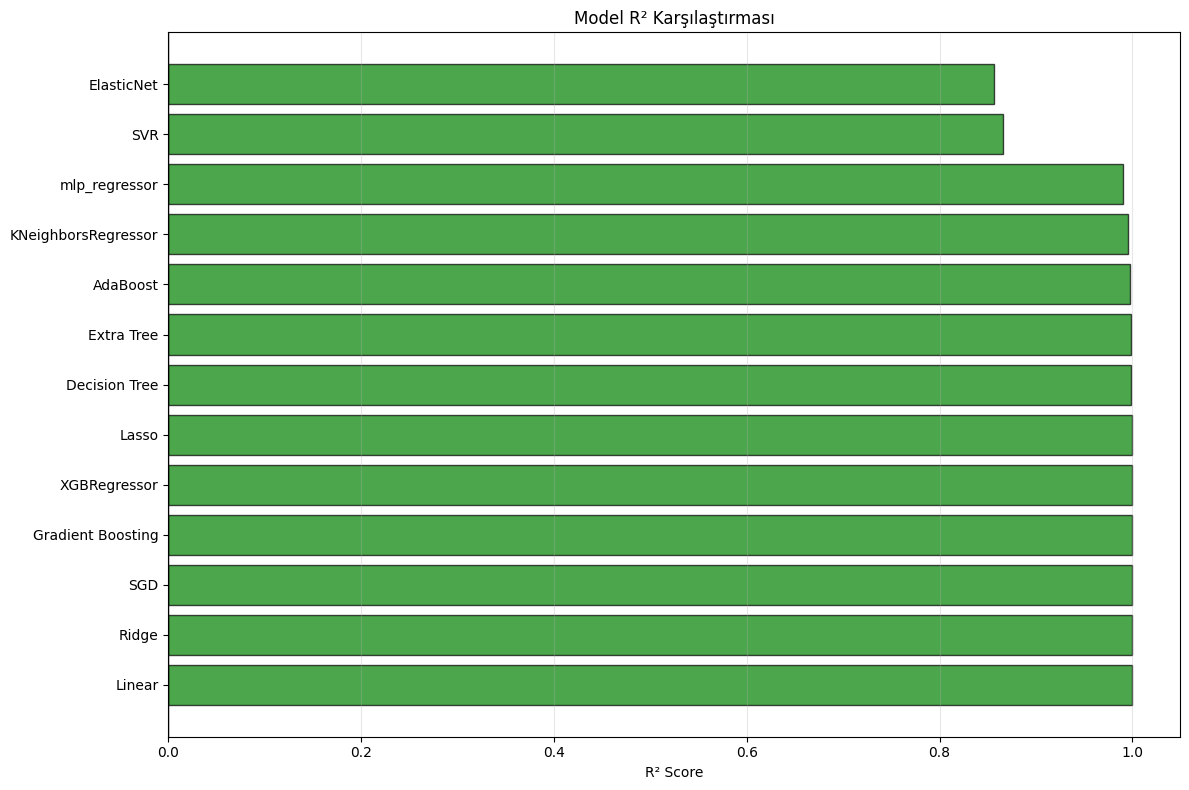

In [10]:
# R² Score görselleştirmesi
plt.figure(figsize=(12, 8))
colors = ['green' if r > 0 else 'red' for r in results['R_Squared']]
plt.barh(results.index, results['R_Squared'], color=colors, alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.xlabel('R² Score')
plt.title('Model R² Karşılaştırması')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## Sonuç

Bu notebook'ta:
- ✓ Tarih sütunu **Year**, **Month**, **Day** olarak ayrıldı
- ✓ Teknik indikatörler (MA, RSI, MACD, Bollinger Bands) eklendi
- ✓ **algo_test(X, y)** fonksiyonu ile tüm modeller karşılaştırıldı
- ✓ Feature engineering ile **pozitif R²** değeri hedeflendi